# Importing the Data 

In [98]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import collections
from collections import Counter

In [99]:
with open('interactions.pickle', 'rb') as handle:
    my_dict = pickle.load(handle)

# Functionality 3 - Shortest Ordered Route

It takes in input:

* An interval of time
* A sequence of users p = [p_2, ..., p_n-1]
* Initial user p_1 and an end user p_n

Implement an algorithm that returns the shortest walk that goes from user p_j to p_n, and that visits in order the nodes in p. The choice of p_j and p_n can be done randomly (or if it improves the performance of the algorithm you can also define it in any other way)

Consider that:

* The algorithm needs to handle the case that the graph is not connected, thus not all the nodes in p are reachable from p_1. In such scenario, it is enough to let the program give in output the string "Not possible".
* That the graph is weighted
* Since we are dealing with walks, you can pass more than once on the same node p_i, but you have to preserve order. E.g.: if you pass through p_2 and you are going to p_3, you can pass through p_10, but once you will be in p_9, you will have to go back to p_10 as well.

In [100]:
def from_date_to_int(date):
    '''
    INPUT: (day,month,year)
    OUTPUT: correspondent integer
    '''
    if date[1]==2:
        integer=date[0]+date[1]*28+(date[2]-1970)*365
    if date[1] in [4,6,9,11]:
        integer=date[0]+date[1]*30+(date[2]-1970)*365
    else:
        integer=date[0]+date[1]*31+(date[2]-1970)*365
    return(integer)


def convert_interval(interval):
    '''
    INPUT= interval of time in format [(dd,mm,yyyy),(dd,mm,yyyy)] --> [start,end]
    OUTPUT: interval of time in format [encoded_start,encoded_end] where encoded are integers values
    '''
    new_int=[]
    for date in interval:
        new_int.append(from_date_to_int(date))
    
    return( new_int)

In [101]:
def flatten_f(array_to_flatten):
    '''
    Function to flatten a list
    '''
    return [item for sublist in array_to_flatten for item in sublist]

In [102]:
def filter_by_timestamps_f(initial_time,final_time,dict_to_filter):
    '''
    Function that filters a graph and leaves only those edges with a timestamp within the interval of initial_time and final_time,
    defined by the user. Function currently creates a new dictionary but it can be modified so that it updates the existing dictionary.
    '''
    #Create new dictionary
    filtered_dictionary = {}
    for each_key in dict_to_filter: #For each key in the dictionary
        to_test = np.array(dict_to_filter[each_key])[:,1] #Extract only the timestamps 
        indexes_to_filter = flatten_f(np.where(np.bitwise_and(to_test>initial_time,to_test<final_time))) #Get indexes of the timestamps that are within the desired time intervals
        values_for_key = dict_to_filter[each_key] #Extracts all edges associated with a specific key
        
        #Redefine values of a particular key
        filtered_dictionary.update({each_key: [values_for_key[i] for i in indexes_to_filter]}) #Keeps only those edges that have timestamps within desired time intervals.
    return(filtered_dictionary)

In [103]:
def standardize_weights_f(dict_to_standardize):
    '''
    Function used to summarise all edges with different weights into 1 single edge in a directed graph. It converts a multigraph in a graph. 
    '''
    #Create new dictionary
    standard_weighs_dictionary = {}
    for each_key in dict_to_standardize:
        if len(dict_to_standardize[each_key]) != 0: #If after the filtering the key doesn't have any edges, ignore that key. 
            #For each key, count how many times each associated vertex appears, and assign that as weight between the key and outgoing vertex
            standard_weighs_dictionary.update({each_key: list(collections.Counter(np.array(dict_to_standardize[each_key])[:,0]).items())})
    
    return(standard_weighs_dictionary) 

# Dijkstra Implementation filtered_dict

In [104]:
def dijkstra_f(graph_to_analyze, start_vertex):
    '''
    Function used to run Dijkstra algorithm 
    '''
    #****************************************1) Collect all vertexes in the graph**********************************
    #Collect all keys (vertexes) in the graph
    #Problem: There are other vertexes that are not keys since the graph is directed and also disconnected. We should consider them too. 
    related_nodes = list()
    for each_key in graph_to_analyze.keys():
        related_nodes.append([i for i in np.array(graph_to_analyze[each_key])[:,0]])
    
    #Union of sets: keys of the graph and vertexes that are not keys of the graph but still exist
    vertexes = set(graph_to_analyze.keys()).union(set(flatten_f(related_nodes)))
    
    #*************************************2) Track which vertexes are still unvisited******************************
    unvisited_vertexes = vertexes 
    #***********************************3) Keep track of the smallest distances to each node***********************
    #All vertexes are set to have an infinite distance at the beginning. Then they'll be updated
    default_distance = float('inf')
    smallest_dist_dict = {k: default_distance for k in vertexes}
    #Set distance of the starting vertex as zero
    smallest_dist_dict[start_vertex] = 0
    
    #*******4) Keep track of the parent with the smallest distance from which we reach each visited vertex*********
    parent_vertex = {k: 'nd' for k in vertexes}
    
    #Now while we still have vertexes that haven't been visited yet... keep rolling
    while(len(unvisited_vertexes)>0):
        #Create another dictionary with weights only for the unvisited vertexes
        #We use this to select the vertex with the smallest distance and then move to it... 9 to 7 in dict_test_2
        dict_unvisited_dist = {each_unvisited_node: smallest_dist_dict[each_unvisited_node] for each_unvisited_node in unvisited_vertexes}
        
        #We select, from the dictionary of unvisited vertexes, the vertex with the smallest weight
        selected_vertex = min(dict_unvisited_dist, key=dict_unvisited_dist.get)
        #We remove the selected vertex from unvisited as it is already visited. 
        unvisited_vertexes.remove(selected_vertex)
        
        #Now we have to update the distances from the selected vertex to each vertex that is related to it. 
        if(selected_vertex in graph_to_analyze.keys()): #If there are edges that go out from the selected vertex (aka is a key in graph) update distances of outgoing nodes
            for each_related_vertex, dist_related_vertex in graph_to_analyze[selected_vertex]:
                #If the distance from the selected vertex plus the dist to the related vertex is smaller than the already reported dist of relat vertex...update!
                combined_dist = smallest_dist_dict[selected_vertex] + (1/dist_related_vertex) #Must be 1/dist_related_vertex since a bigger weight means more interactions. Dijkstra only on dist_related_vertex would find the least important relationships.
                if(combined_dist < smallest_dist_dict[each_related_vertex]):
                    #Update the just discovered shortest distance to the related vertex of the selected vertex
                    smallest_dist_dict[each_related_vertex] = combined_dist
                    #Keep track of who is the selected vertex that lead to the related_vertex with the shortest dist (aka as the parent)
                    parent_vertex[each_related_vertex] = selected_vertex
            #print(len(unvisited_vertexes))
    
    return smallest_dist_dict, parent_vertex

# Function to rebuild the path

In [105]:
def reconstruct_path_f(graph_to_analyze_inp,starting_vertex_inp,ending_vertex_inp):
    '''
    Runs Dijkstra from the starting vertex. Gets dict of min distance from starting_vertex to each vertex that can be reached from it
    and gets dict of the parent vertex that lead to each vertex that can be reached from starting vertex. Then reconstructs the path.
    '''
    min_dist_dict, parent_dict = dijkstra_f(graph_to_analyze_inp,starting_vertex_inp) 
    
    #List to reconstruct the path that lead to each vertex
    path_to_goal = list()
    #path_to_goal.append(ending_vertex)
    #Define the goal vertex from which we will start constructing the path that lead to it from the starting_vertex
    goal = starting_vertex_inp
    
    #While we haven't reached our goal vertex, keep rolling...unless it's impossible to construct a path between starting and ending vertex
    #stopping_clause = False
    while ending_vertex_inp != goal:
        #If there's no parent vertex... it was not possible to reach ending_vertex from starting_vertex, so stop searching
        if (ending_vertex_inp not in parent_dict.keys()) or (parent_dict[ending_vertex_inp] == 'nd'):
            path_to_goal.clear()
            return(print("Impossible to reach vertex",ending_vertex_inp,"from vertex",goal,"!"))
            #stopping_clause = True
            break #Stop searching
        else:
            #print(parent_dict[ending_vertex]) #Debug
            #Add the parent of the list to reconstruct the path that lead from starting_vertex to ending_vertex
            path_to_goal.append(parent_dict[ending_vertex_inp])
            #Redefine parent vertex for next iteration and continue searching backwards
            ending_vertex_inp = parent_dict[ending_vertex_inp]
    return(path_to_goal[::-1])

# Functionality 3
Give a list and return the shortest walk between the starting_vertex and ending_vertex that visits in order the vertex in the list

In [106]:
def functionality_3(graph_to_analyze_inp, interval_time, p1, pn, p): #Where interval of time has to have a default
    '''
    Function that takes a graph, an interval of time and 1) A starting vertex 2) An ending (or goal) vertex 3) And a list of vertexes.
    The goal is to find the shortest route between the starting vertex and the ending vertex, that passes through the list of vertexes in order.
    For this the function breaks the list in couples of subsequent vertexes and finds the shortest route between them
    Collects the shortest paths in a list and finds, at the end, the shortest route between starting and ending vertex. 
    '''
    #First filter the graph by time interval
    converted_interval=convert_interval(interval_time) #Transforming inputs of date intervals into integers
    #Filter the graph by the timestamps (converted to integers) given by the user
    filtered_dict = filter_by_timestamps_f(converted_interval[0],converted_interval[1],graph_to_analyze_inp)
    #Second standardize the filtered graph to sum up the weights of all the edges with the same direction between each pair of vertexes
    graph_to_analyze = standardize_weights_f(filtered_dict)

    if isinstance(p, list):
        p.insert(0,p1) #Set the parameter p1 as the first element of the list p.
        p.insert(len(p),pn) #Set the parameter pn as the last element of the list p. 
        
        shortest_route = list() #Define a list to collect the shortest route between a couple of vertexes
        
        for i in range(0,len(p)-1): #Goes through the list given by the user taking couples of vertexes
            
            starting_vertex = p[i] #Take the first vertex of the couple
            ending_vertex = p[i+1] #Take the second vertex of the couple
            
            #Explore the shortest path between starting and ending vertex
            path = reconstruct_path_f(graph_to_analyze,starting_vertex,ending_vertex) 
            #Check if the returned type is None
            if path is None:
                break
            #Save the path found between the 2 vertexes
            shortest_route.extend(path) 
            
            #If is the last iteration, and all the paths have been found, just append the goal vertex to the list.
            if i == (len(p)-2): 
                shortest_route.append(pn) #This can be removed. 
    else:
        print("Input p is not a list. Please insert a object of type list.")
    
    return shortest_route

In [107]:
path_f3 = functionality_3(my_dict,[(4,1,2011),(6,1,2011)],267,589854,[476,1053,1968])

In [108]:
path_f3

[267,
 48465,
 8992,
 289466,
 84325,
 68105,
 155077,
 296568,
 419970,
 449907,
 476,
 386579,
 187606,
 524436,
 481061,
 456,
 585737,
 415784,
 317283,
 165520,
 505259,
 1053,
 501518,
 501146,
 556363,
 14955,
 212443,
 429982,
 511601,
 13005,
 1968,
 19563,
 252047,
 511601,
 429982,
 573261,
 589854]

In [110]:
#First filter the graph by time interval
converted_interval=convert_interval([(4,1,2011),(6,1,2011)]) #Transforming inputs of date intervals into integers
#Filter the graph by the timestamps (converted to integers) given by the user
filtered_dict = filter_by_timestamps_f(converted_interval[0],converted_interval[1],my_dict)
#Second standardize the filtered graph to sum up the weights of all the edges with the same direction between each pair of vertexes
graph_to_analyze = standardize_weights_f(filtered_dict)

In [111]:
def visualization_f3(graph_to_visualize, path_to_visualize):
    G = nx.Graph()

    for each_key in graph_to_visualize.keys():
        for each_vertex in graph_to_visualize[each_key]:
            G.add_edge(each_key,each_vertex[0])
    
    res = path_to_visualize
    
    k = G.subgraph(res)
    starting_node = G.subgraph(path_f3[0])
    ending_node = G.subgraph(path_f3[-1])
    
    plt.figure(figsize=(20,10))

    pos = nx.spring_layout(G,k = 1, iterations=50, seed=7)
    # nodes
    nx.draw_networkx_nodes(G, pos, alpha=0.3, node_size=10)
    # edges
    nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.2)
    
    nx.draw_networkx(k, pos=pos,with_labels=True, node_color = 'r', node_size = 30)
    nx.draw_networkx(starting_node, pos=pos,with_labels=True, node_color = 'y', node_size = 100)
    nx.draw_networkx(ending_node, pos=pos,with_labels=True, node_color = 'y', node_size = 100)
    nx.draw_networkx_edges(k, pos, width=1, edge_color = 'm')

    plt.show()

In [112]:
G = visualization_f3(graph_to_analyze)

In [113]:
res = path_f3

In [134]:
k = G.subgraph(res)
starting_node = G.subgraph(path_f3[0])
ending_node = G.subgraph(path_f3[-1])

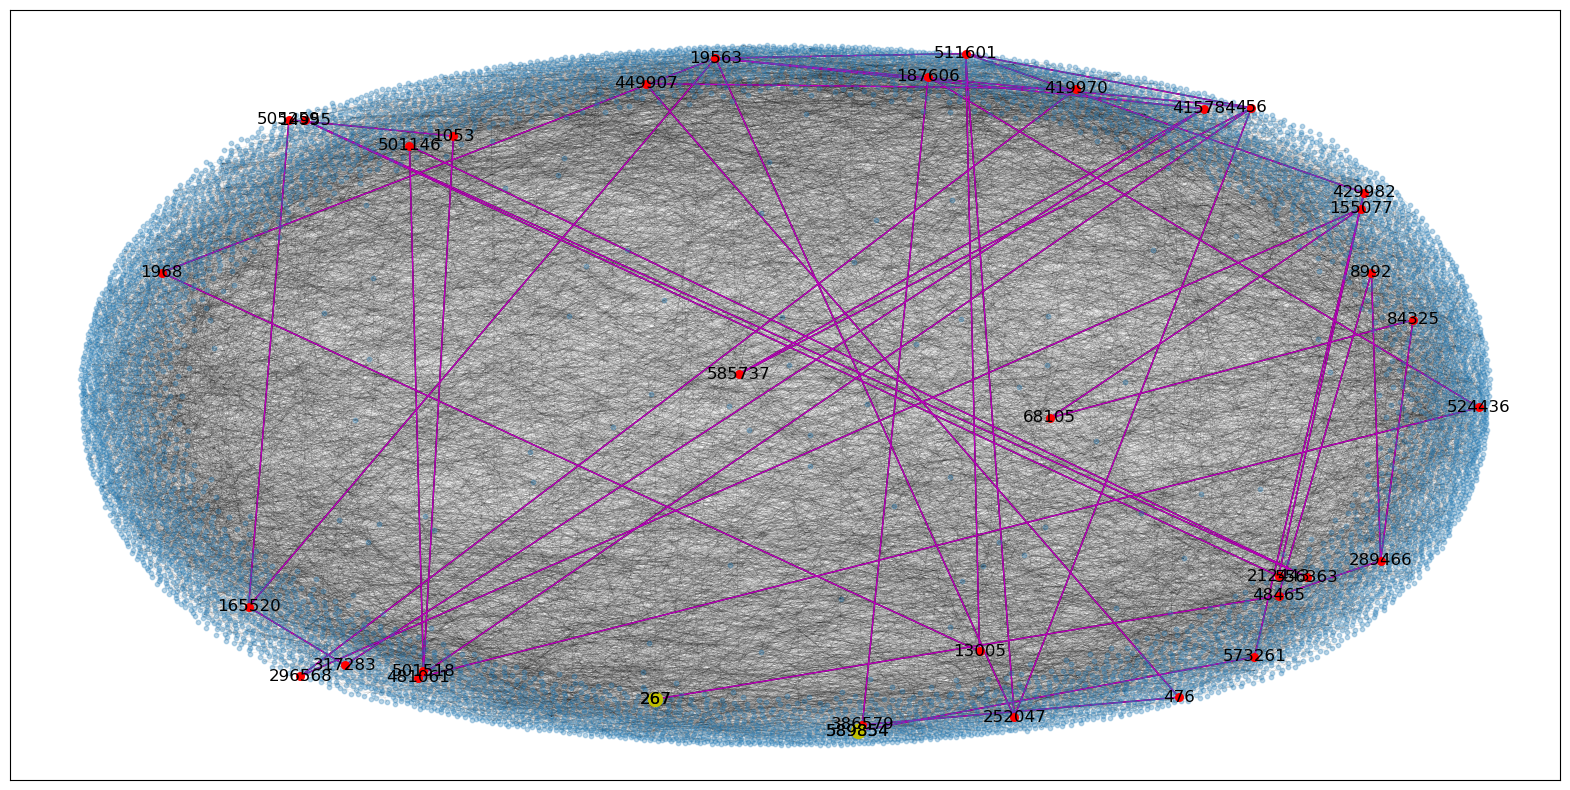

In [135]:
plt.figure(figsize=(20,10))

pos = nx.spring_layout(G,k = 1, iterations=50, seed=7)
# nodes
nx.draw_networkx_nodes(G, pos, alpha=0.3, node_size=10)
# edges
nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.2)
    
nx.draw_networkx(k, pos=pos,with_labels=True, node_color = 'r', node_size = 30)
nx.draw_networkx(starting_node, pos=pos,with_labels=True, node_color = 'y', node_size = 100)
nx.draw_networkx(ending_node, pos=pos,with_labels=True, node_color = 'y', node_size = 100)
nx.draw_networkx_edges(k, pos, width=1, edge_color = 'm')

#othersubgraph = G.subgraph(range(4,G.order()))
#nx.draw_networkx(othersubgraph, pos=pos, node_color = 'b')
plt.show()